## Установка, импорт библиотек и подключение диска

In [ ]:
%%capture
!pip install rembg
from rembg import remove
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models
import shutil
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Предобработка данных

Объявление исходной (необработанной) и конечной (обработанной) директорий

In [ ]:
data_root = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Tarelki/plates/'
os.makedirs(os.path.join(data_root, 'clean'), exist_ok=True)
data_clean = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Tarelki/plates/clean'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test', 'clean']


#### Функции преобразования данных  
Преобразуют исходники так, что на картинках останутся только тарелки посередине (без фона)

In [ ]:
def process_image(input_path, output_path):
    # Удаление фона
    with open(input_path, "rb") as input_file:
      input_data = input_file.read()
      output_data = remove(input_data)
    with open(output_path, "wb") as output_file:
      output_file.write(output_data)

    # Избалвение от ненужного "паддинга", чтобы на картинке была только тарелка в центре
    image = cv2.imread(output_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # здесь применяю гауссово разымытие, чтобы лучше найти контур
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # следующая функция принимает первым параметром изображение, вторым — пороговое значение,
    # третьим — максимальное значение, которое присваивается значениям пикселей,
    # превышающим пороговое значение, таким образом, любое значение пикселя, превышающее 20,
    # устанавливается равным 255, а любое значение, которое меньше 20, устанавливается равным 0
    T, thresh_img = cv2.threshold(blurred, 20, 255,
                                  cv2.THRESH_BINARY)

    # Создание маски, выделяющей объект;
    # нахождение контуров; получение прямоуголника, ограничивающего объект; обрезка
    _, binary_mask = cv2.threshold(thresh_img, 20, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    # Порой функция неправильно обрезает изображение, и от исходника остается
    # один пиксель. Я задал проверку длин получившегося прямоугольника
    # относительно размеров изображения
    if (w > (image.shape[0]/6)) and (h > (image.shape[1]/6)):
      cropped_image = image[y:y+h, x:x+w]
      cv2.imwrite(output_path, cropped_image)


class_names = ['cleaned', 'dirty']
def process_images_in_directory(input_directory):
    # Если обрабатывается обучающая выборка, создам соответствующие директории для чистых и грязных тарелок
    if input_directory == 'train':
      for class_name in class_names:
        os.makedirs(os.path.join(data_clean, input_directory, class_name), exist_ok=True)

      for class_name in class_names:
        source_dir = os.path.join(data_root, input_directory, class_name)
        for i, filename in tqdm(enumerate(os.listdir(source_dir)), desc='Train processing'):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                input_path = os.path.join(source_dir, filename)
                output_path = os.path.join(data_clean, input_directory, class_name, filename)
                process_image(input_path, output_path)

    # В случае тестовой выборки обрабатываем каждую картинку и складирую в папку "/test/unlabeled"
    elif input_directory == 'test':
      os.makedirs(os.path.join(data_clean, input_directory, 'unlabeled'), exist_ok=True)
      source_dir = os.path.join(data_root, input_directory)
      for i, filename in tqdm(enumerate(os.listdir(source_dir)), desc='Test processing'):
        if filename.endswith(".jpg") or filename.endswith(".png"):
          input_path = os.path.join(source_dir, filename)
          output_path = os.path.join(data_clean, input_directory, 'unlabeled', filename)
          process_image(input_path, output_path)

# Необходимо изменить класс, чтобы с каждым тестовым изображением шла доп. инфа о его пути.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
process_images_in_directory('train')
process_images_in_directory('test')

Train processing: 21it [01:08,  3.26s/it]
Train processing: 21it [01:08,  3.25s/it]
Test processing: 745it [42:17,  3.41s/it]


#### Трансформация изображений.  
Здесь каждое train изображение вращаю на угол (90/180/270) и применяю к нему "базовую" аугментацию - вырезание центра (размер 160х160), приведение к размеру 224х224, преобразование в тензор и нормализация.  
Далее наполняю датасет всеми аугментированными изображениями. Итоговый размер - 160 картинок.  
К test применяю только базовое преобразование.

Объявление рабочих директорий

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Tarelki/plates/clean/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Tarelki/plates/clean/test'

In [ ]:
rotation = [transforms.RandomRotation(degrees=(90,90)),
            transforms.RandomRotation(degrees=(180,180)),
            transforms.RandomRotation(degrees=(270,270))]
base = [transforms.CenterCrop(160),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

train_dataset = torchvision.datasets.ImageFolder(train_dir, transforms.Compose(base))
for i in rotation:
    aug = transforms.Compose([i] + base)
    train_dataset += torchvision.datasets.ImageFolder(train_dir, aug)

test_dataset = ImageFolderWithPaths(test_dir, transforms.Compose(base))

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

len(train_dataloader), len(train_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(10, 160)

#### Визуализация преобразования

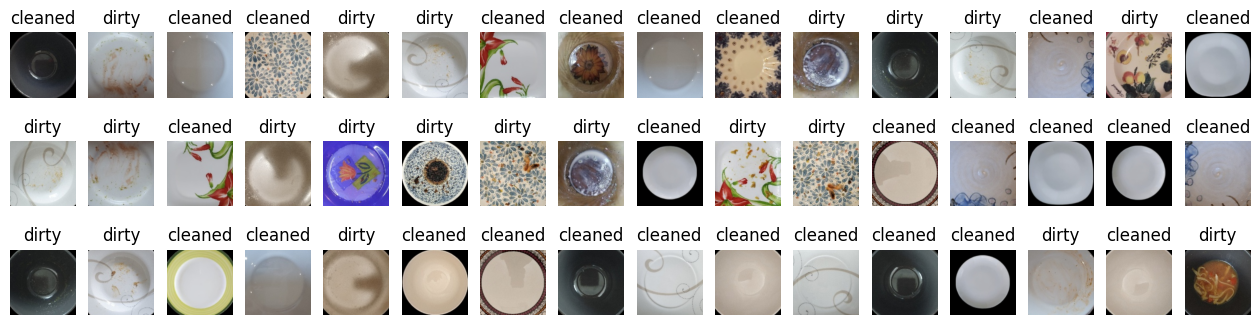

In [ ]:
plt.figure(figsize=(batch_size, 4))

image_iter = iter(train_dataloader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

number_of_batches = 3
for i in range(number_of_batches):
    X_batch, y_batch = next(image_iter)
    for j in range(0, len(X_batch)):
        plt.subplot(number_of_batches, len(X_batch), i * len(X_batch) + j + 1)
        plt.title(class_names[y_batch[j].item()])
        plt.axis('off')
        plt.imshow((X_batch[j].permute(1, 2, 0).numpy() * std + mean).clip(0, 1))

## Процесс обучения ResNet18
#### Визуализация процесса обучения


In [ ]:
def train_model(model,
                loss,
                optimizer,
                scheduler,
                num_epochs):

    epoch_loss_history_train = []
    epoch_acc_history_train = []

    for epoch in range(num_epochs):
        dataloader = train_dataloader
        scheduler.step()
        model.train()

        running_loss = 0.
        running_acc = 0.

        for inputs, labels in dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)
            loss_value.backward()
            optimizer.step()

            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(epoch + 1, epoch_loss, epoch_acc), flush=True)

        epoch_loss_history_train.append([epoch_loss])
        epoch_acc_history_train.append([epoch_acc.data.cpu()])

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_loss_history_train, c='g')
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_acc_history_train, c='g')
    plt.title('Accuracy')
    plt.show()

    return model

### Изменение исходной нейросети  
Замораживание первых 3 слоев  
Разморозка последнего и изменение полносвязного слоя

In [ ]:
torch.manual_seed(0)

# Использование переноса обучения
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for layer in [model.layer1, model.layer2, model.layer3]:
    for param in layer.parameters():
        param.requires_grad = False
for layer in [model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

classifier = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2)
    )

model.fc = classifier
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.layer4.parameters()) + \
                             list(model.fc.parameters()), lr=1.0e-3, amsgrad=True)
# Загоняю в планировщик уменьшение градиентного шага в 10 раз каждую 7 эпоху
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


1 Loss: 0.4121 Acc: 0.8188
2 Loss: 0.0448 Acc: 0.9812
3 Loss: 0.1468 Acc: 0.9688
4 Loss: 0.1696 Acc: 0.9500
5 Loss: 0.0692 Acc: 0.9750
6 Loss: 0.0385 Acc: 0.9812
7 Loss: 0.0108 Acc: 1.0000
8 Loss: 0.0116 Acc: 1.0000


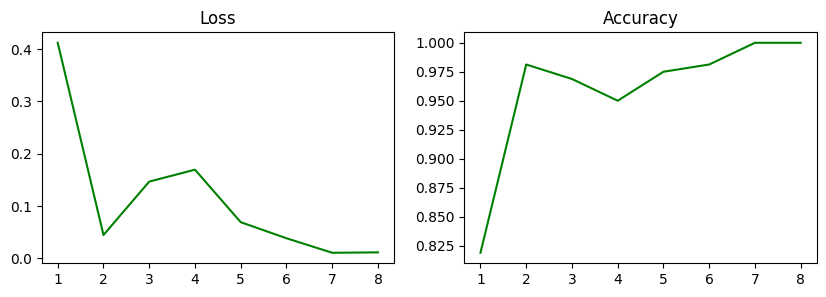

In [ ]:
torch.manual_seed(0)

train_model(model, loss, optimizer,
            scheduler,
            num_epochs=8);

## Проверка нейросети на тестовой выборке

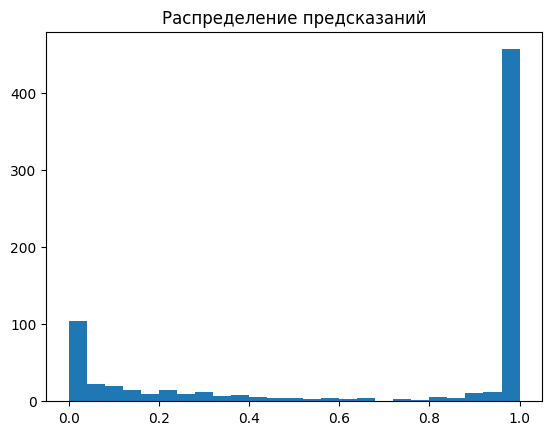

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)
plt.hist(test_predictions, bins=25)
plt.title('Распределение предсказаний')
plt.show()

#### Визуализация (картинка + уверенность в "грязности" тарелки)

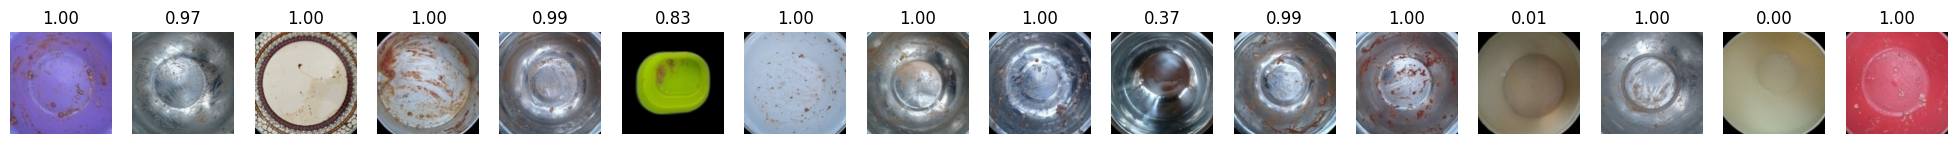

In [ ]:
plt.figure(figsize=(25,10))
def show_input(loader):
  inputs, labels, paths = next(iter(loader))
  for j, (img, pred) in enumerate(zip(inputs, test_predictions[0:len(inputs)])):
    plt.subplot(2, len(inputs), len(inputs) + j + 1)
    plt.title(f'{pred:.2f}')
    normalized_image = (img.permute(1, 2, 0).numpy() * std + mean).clip(0, 1)
    plt.axis('off')
    plt.imshow(normalized_image)
  plt.show()

show_input(test_dataloader)

## Запись результата классификации

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.8 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Tarelki/plates/clean/test/unlabeled/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

# Порог 0.8 был подобран эмперически и исходя из распределения предсказаний

<ipython-input-56-5b557e7a2811>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty


In [ ]:
submission_df.to_csv('submission.csv')